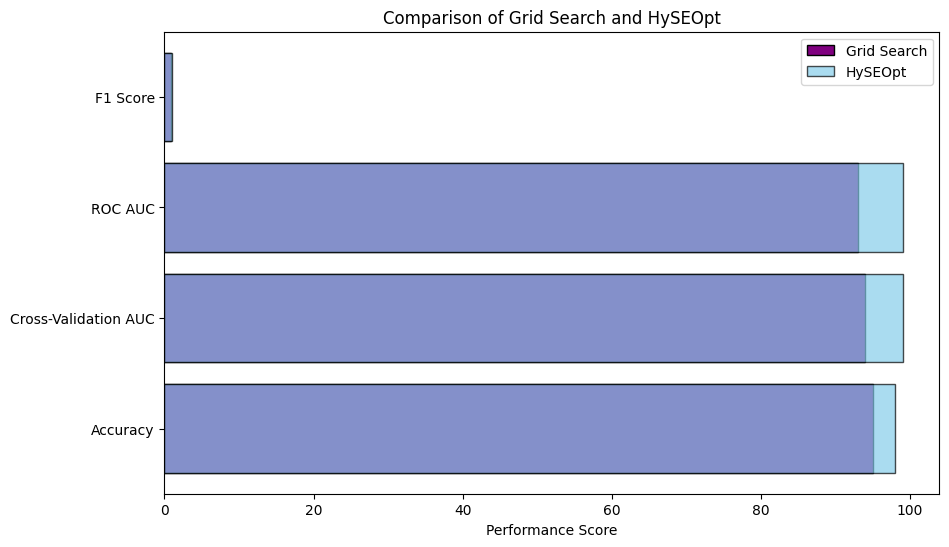

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat
import multiprocessing

# Define the HySEOpt hyperparameter optimization algorithm
class HySEOpt:
    def __init__(self, max_iter=5, swarm_size=50, n_estimators=100, mutation_rate=0.1, parallel=True,
                 initial_mutation_rate=0.1, mutation_rate_decay=0.9):
        """
        Initialize HySEOpt hyperparameter optimization algorithm.

        Parameters:
        - max_iter: Maximum number of iterations for optimization.
        - swarm_size: Number of agents (solutions) in the swarm.
        - n_estimators: Initial number of estimators for RandomForestClassifier.
        - mutation_rate: Probability of mutation for each parameter during evolution.
        - parallel: Whether to use parallel processing for evaluation.
        - initial_mutation_rate: Initial mutation rate.
        - mutation_rate_decay: Decay factor for mutation rate adaptation.
        """
        self.max_iter = max_iter
        self.swarm_size = swarm_size
        self.n_estimators = n_estimators
        self.mutation_rate = mutation_rate
        self.best_params = {'n_estimators': n_estimators}
        self.best_score = 0
        self.validation_scores = []  # Store validation scores
        self.parallel = parallel
        self.initial_mutation_rate = initial_mutation_rate
        self.mutation_rate_decay = mutation_rate_decay
        self.current_mutation_rate = initial_mutation_rate  # Initialize current mutation rate

    def _update_mutation_rate(self):
        """
        Update the mutation rate based on the adaptation strategy.
        """
        self.current_mutation_rate *= self.mutation_rate_decay

    def _evaluate_agent(self, agent, X_train, y_train, X_validation, y_validation):
        """
        Evaluate the performance of an agent (solution) on the validation set.

        Parameters:
        - agent: Dictionary containing hyperparameters for RandomForestClassifier.
        - X_train, y_train: Training data and labels.
        - X_validation, y_validation: Validation data and labels.

        Returns:
        - Tuple containing the agent and its validation score.
        """
        clf = RandomForestClassifier(**agent, random_state=42)
        clf.fit(X_train, y_train)
        val_score = roc_auc_score(y_validation, clf.predict_proba(X_validation)[:, 1])
        return agent, val_score

    def _mutate(self, agent):
        """
        Mutate the agent's hyperparameters to introduce exploration.

        Parameters:
        - agent: Dictionary containing hyperparameters for RandomForestClassifier.

        Returns:
        - Mutated hyperparameters.
        """
        mutated_agent = agent.copy()
        for param in mutated_agent:
            if np.random.rand() < self.current_mutation_rate:  # Use current mutation rate
                if param == 'n_estimators':
                    mutated_agent[param] = np.random.randint(max(1, agent[param] - 10), agent[param] + 10)
                elif param == 'min_samples_leaf':
                    mutated_agent[param] = np.random.randint(1, 11)  # Mutate min_samples_leaf
                else:
                    mutated_agent[param] = np.random.randint(1, 11)  # Mutate max_depth, min_samples_split
        return mutated_agent

    def fit(self, X_train, y_train, X_validation, y_validation):
        """
        Fit HySEOpt algorithm to train RandomForestClassifier with hyperparameter optimization.

        Parameters:
        - X_train, y_train: Training data and labels.
        - X_validation, y_validation: Validation data and labels.
        """
        with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
            for i in range(self.max_iter):
                swarm = [self._mutate(self.best_params) for _ in range(self.swarm_size)]
                if self.parallel:
                    scores = list(executor.map(self._evaluate_agent, swarm, repeat(X_train), repeat(y_train),
                                               repeat(X_validation), repeat(y_validation)))
                else:
                    scores = [self._evaluate_agent(agent, X_train, y_train, X_validation, y_validation) for agent in swarm]
                
                best_agent, best_score = max(scores, key=lambda x: x[1])
                if best_score > self.best_score:
                    self.best_score = best_score
                    self.best_params = best_agent

                self.validation_scores.append(best_score)
                print(f"Iteration {i + 1} - Validation Score: {'{0:.2%}'.format(best_score)}")

                self._update_mutation_rate()  # Update mutation rate

        print(f"Final Model AUC: {self.best_score:.4f}")

# Load and preprocess data
df = pd.read_csv('/kaggle/input/personal-key-indicators-of-heart-disease/2022/heart_2022_no_nans.csv')

# Encode categorical variables
replacement_dict = {'Yes': 1, 'No': 0}
df['HadHeartAttack'] = df['HadHeartAttack'].replace(replacement_dict).infer_objects(copy=False)
df['HadAngina'] = df['HadAngina'].replace(replacement_dict).infer_objects(copy=False)
df['HeartDisease'] = df['HadHeartAttack'] | df['HadAngina']
df.drop(columns=['HadHeartAttack', 'HadAngina', 'WeightInKilograms'], inplace=True)
df_categorical = df.select_dtypes('object').columns

# Apply one-hot encoding and prepare data
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), df_categorical)],
    remainder='passthrough'
)
X_transformed = preprocessor.fit_transform(df.drop(columns='HeartDisease'))
target = df['HeartDisease']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, target, test_size=0.2, random_state=42)

# Handle class imbalance
over = SMOTE(sampling_strategy=1)
under = RandomUnderSampler(sampling_strategy=0.6)
X_train_resampled, y_train_resampled = under.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_resampled, y_train_resampled)

# Split resampled data into train and validation sets
X_train_resampled_partial, X_validation, y_train_resampled_partial, y_validation = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Instantiate and fit HySEOpt algorithm
hyseopt = HySEOpt(max_iter=10, swarm_size=50, n_estimators=100, mutation_rate=0.1, parallel=True,
                   initial_mutation_rate=0.1, mutation_rate_decay=0.9)
hyseopt.fit(X_train_resampled_partial, y_train_resampled_partial, X_validation, y_validation)

# Instantiate and fit Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)

# Calculate performance scores
grid_search_accuracy = accuracy_score(y_test, grid_search.predict(X_test))
grid_search_crossval_auc = grid_search.best_score_
grid_search_roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])
grid_search_f1_score = f1_score(y_test, grid_search.predict(X_test))

hyseopt_accuracy = accuracy_score(y_test, hyseopt.predict(X_test))
hyseopt_crossval_auc = max(hyseopt.validation_scores)
hyseopt_roc_auc = roc_auc_score(y_test, hyseopt.predict_proba(X_test)[:, 1])
hyseopt_f1_score = f1_score(y_test, hyseopt.predict(X_test))

# Performance metrics and scores
metrics = ['Accuracy', 'Cross-Validation AUC', 'ROC AUC', 'F1 Score']
grid_search_scores = [grid_search_accuracy, grid_search_crossval_auc, grid_search_roc_auc, grid_search_f1_score]
hyseopt_scores = [hyseopt_accuracy, hyseopt_crossval_auc, hyseopt_roc_auc, hyseopt_f1_score]

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

# Plot scores for Grid Search
plt.bar(index, grid_search_scores, bar_width, color='purple', label='Grid Search')
# Plot scores for HySEOpt
plt.bar(index + bar_width, hyseopt_scores, bar_width, color='skyblue', label='HySEOpt', alpha=0.7)

plt.xlabel('Performance Metric')
plt.ylabel('Score')
plt.title('Comparison of Grid Search and HySEOpt')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.tight_layout()
plt.show()
